In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.stats.multitest as multi

from CosinorPy import file_parser, cosinor, cosinor1
from CosinorPy.helpers import df_add_row
from RhythmCount import data_processing as dproc
from RhythmCount import plot

### Priprava podatkov

In [60]:
lj_dez = pd.read_csv("../nesrece_LjubljanaDez_dnevno_2010_2023.csv")
# display(lj_dez)

data = pd.read_csv("../PrometneNesreče.csv")

C:\Users\Hana\AppData\Local\Temp\ipykernel_80764\3572289432.py:4: DtypeWarning: Columns (31,32,33,34,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../PrometneNesreče.csv")


In [61]:
# Nastavljanje pravilnega časovnega pasu
lj_dez['NastanekDatumCas'] = pd.to_datetime(lj_dez['NastanekDatumCas'], format='ISO8601', utc=True, errors='coerce')
lj_dez['NastanekDatumCas'] = lj_dez['NastanekDatumCas'].dt.tz_convert('Europe/Ljubljana')
print(f"NastanekDatumCas column dtype: {lj_dez['NastanekDatumCas'].dtype}")

# data['NastanekDatumCas'] = pd.to_datetime(data['NastanekDatumCas'], format='ISO8601', errors='coerce')
# print(f"NastanekDatumCas column dtype: {data['NastanekDatumCas'].dtype}")

# display(lj_dez)

NastanekDatumCas column dtype: datetime64[ns, Europe/Ljubljana]


## CosinorPy

Preverila bom, če se ritmičnost nesreč, ki so se zgodile v dežju, razlikuje od ritmičnosti nesreč, ki so se zgodile v lepem vremenu. Za nesreče v dežju bom upoštevala vse nesreče, ki so se zgodile na dan, ko je zapadlo vsaj 1.0 mm/h dežja.

In [62]:
# Maska za dež
rain_mask = (lj_dez['rain_sum'] >= 1.0)

lj_dez = lj_dez[rain_mask]
# display(lj_dez)

# Za vsak vnos pridobi znotraj, katere ure se je zgodil
hours = lj_dez['NastanekDatumCas'].dt.hour

accidents_per_hour = hours.value_counts()

# Uredi podatke po vrstnem redu ur (naraščajoče)
accidents_per_hour = accidents_per_hour.sort_index()
# print(accidents_per_hour)

# Ustvari pandas dataframe v formatu, ki bo primeren za uporabo CosinorPy
df_plot = pd.DataFrame({
    "test": "HourlyAccidentsRain",  # konstantna oznaka vseh vrstic
    "x": accidents_per_hour.index,  # Ura (od 0 do 23)
    "y": accidents_per_hour.values  # Število nesreč za tisto uro
})

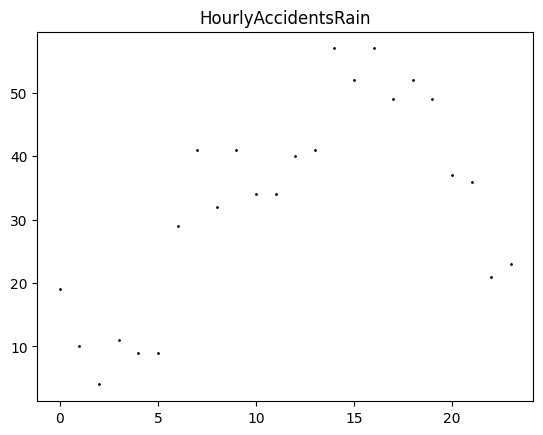

In [63]:
cosinor.plot_data(df_plot, names = ["HourlyAccidentsRain"])

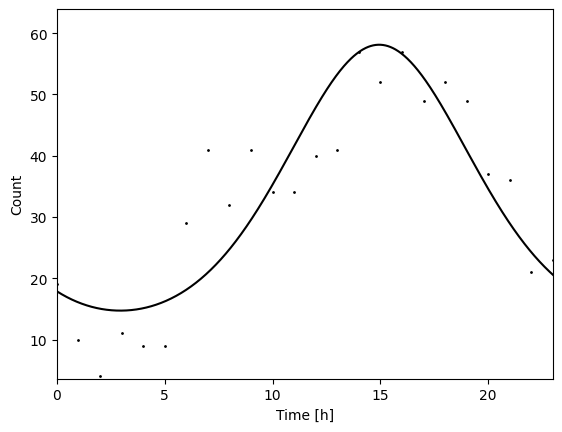

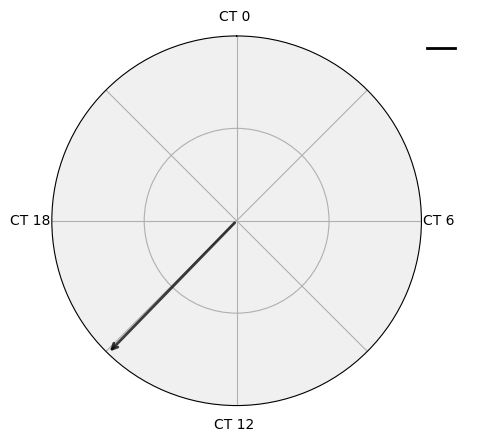

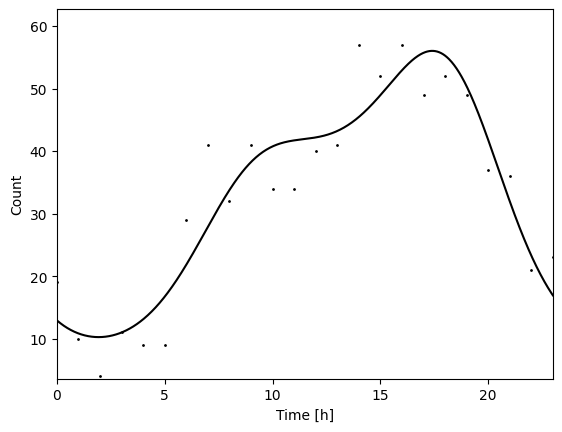

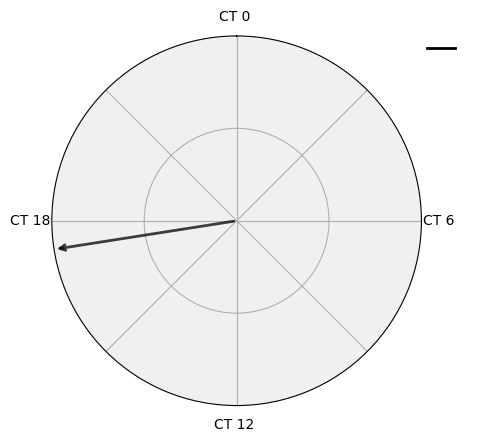

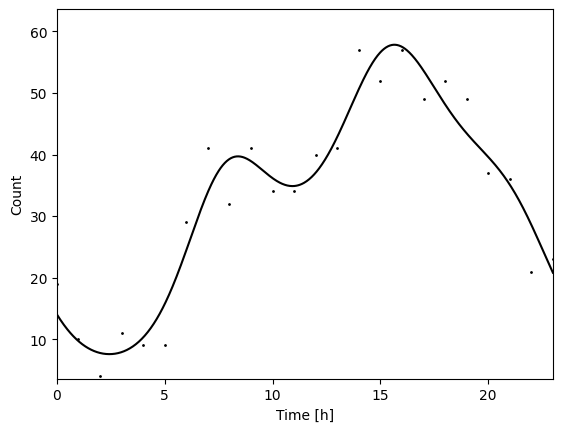

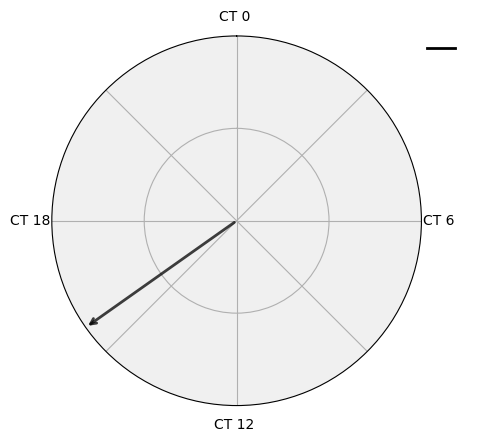

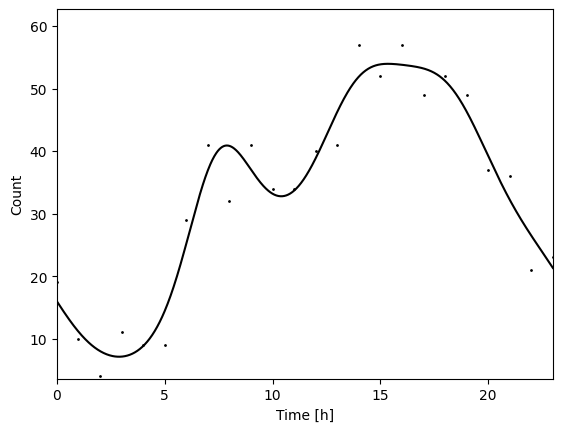

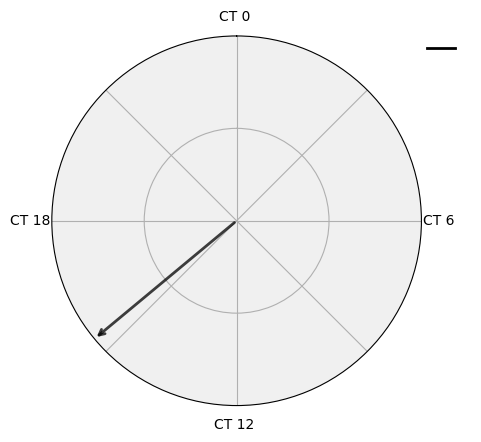

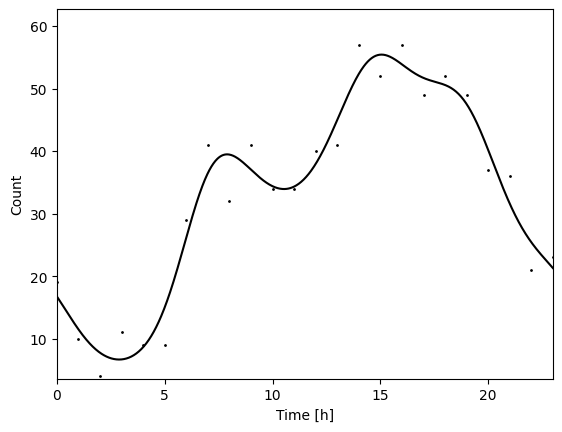

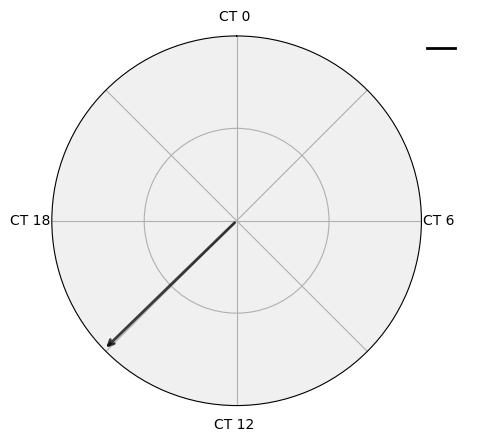

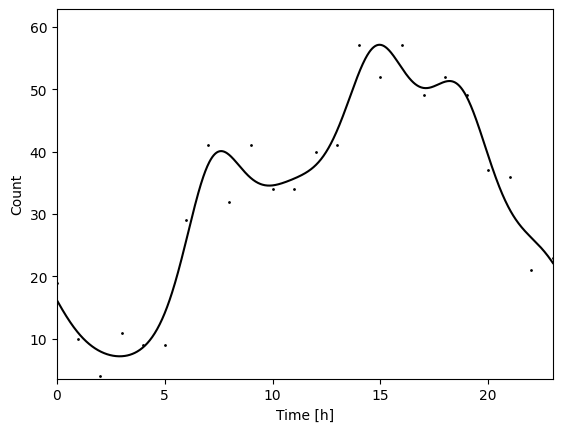

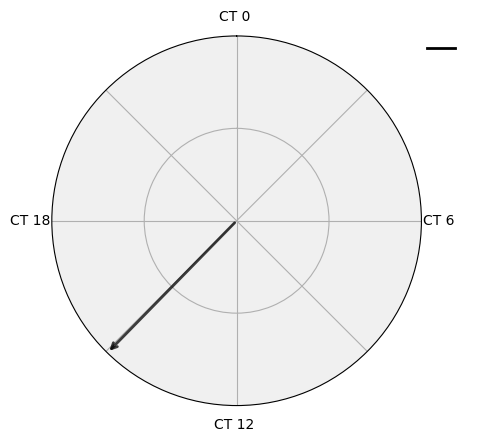

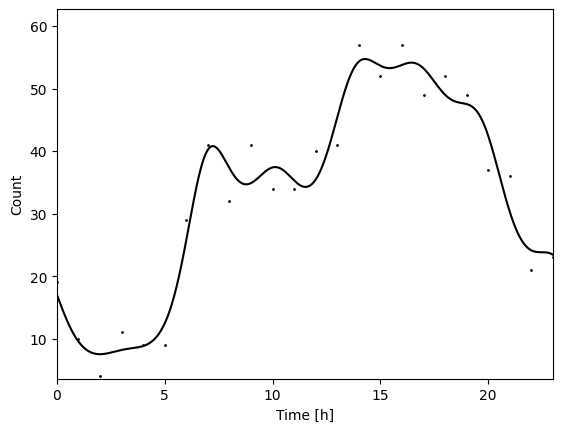

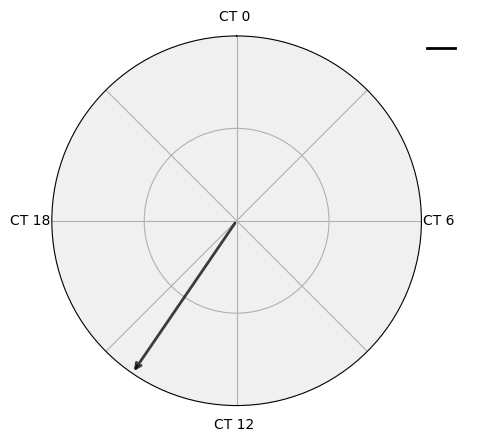

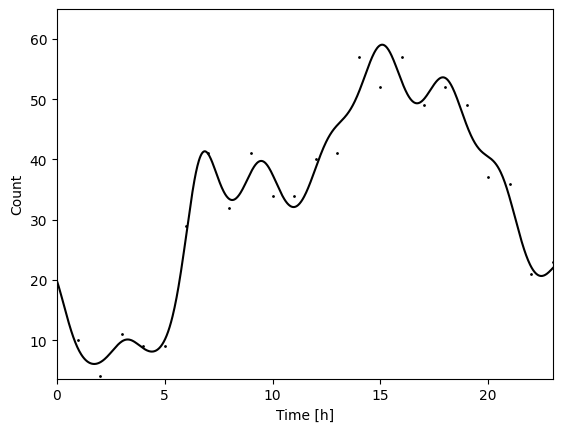

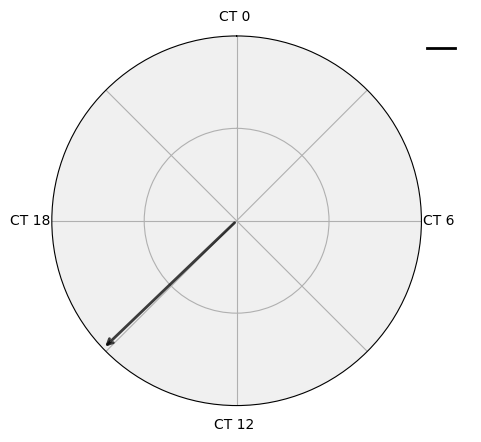

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


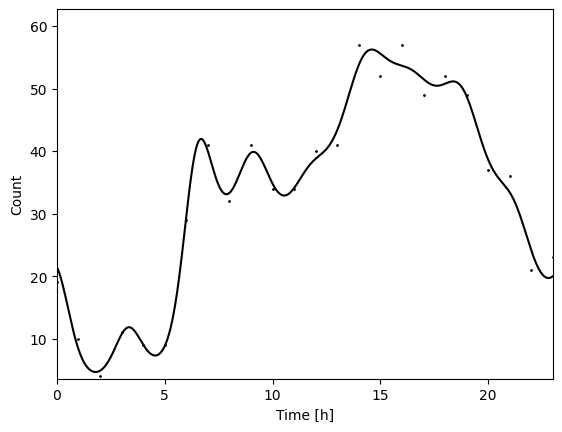

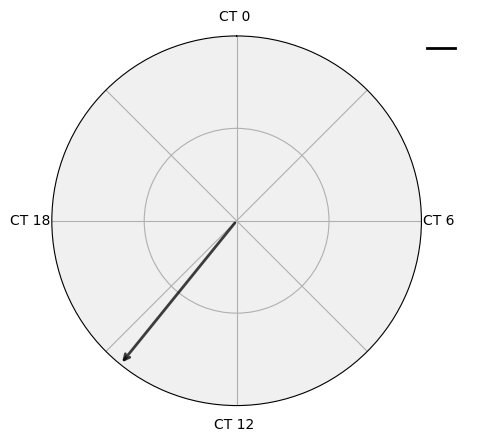

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


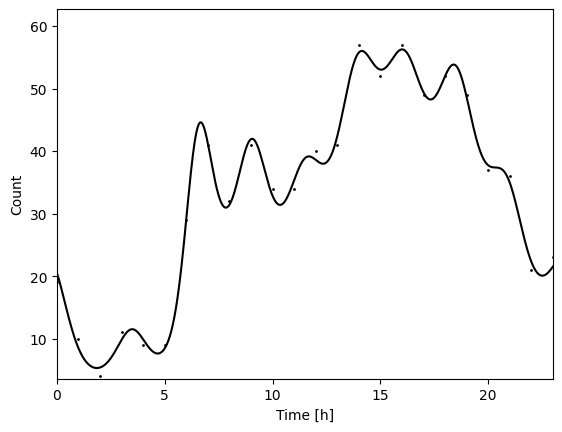

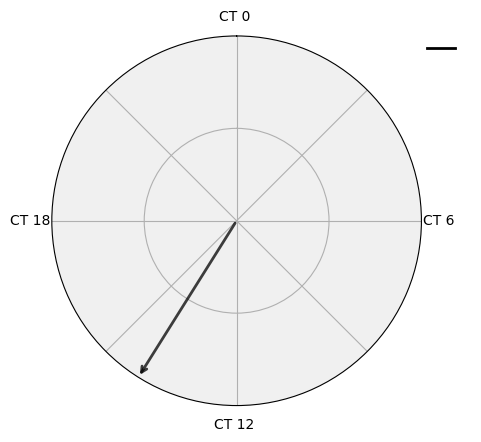

In [64]:
X = df_plot.x.to_numpy()
Y = df_plot.y.to_numpy()

df_results = pd.DataFrame(columns=[
    'test', 'period', 'n_components', 'p', 'q', 'RSS', 
    'log-likelihood', 'prsquared', 'amplitude', 'acrophase', 
    'mesor', 'peaks', 'heights', 'troughs', 'heights2'
], dtype=float)

all_models = []

numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for n_component in numbers:
    results, statistics, rhythm_param, _, _, model = cosinor.fit_me(X, Y, n_components = n_component, period = 24, model_type = 'gen_poisson', plot_margins=False, return_model=True)
    #result_table.append(result)

    # print("Statistics:", statistics.keys())
    # print("Rhythm parameters:", rhythm_param.keys())
    # print("Results attributes:", dir(results))
    # print(results.__dict__.keys())
    # print(results.summary())
    # print("AIC in BIC", results.aic, results.bic)
    # help(results)


    df_results = df_add_row(df_results, {
        'test': 'HourlyAccidentsRain', 
        'period': 24,
        'n_components': n_component,
        'p': statistics['p'], 
        'RSS': statistics['RSS'],
        'log-likelihood': results.llf,        
        'prsquared': results.prsquared,  # Alternative to R²
        'AIC': results.aic,
        'BIC': results.bic,
        'amplitude': rhythm_param['amplitude'],
        'acrophase': rhythm_param['acrophase'],
        'mesor': rhythm_param['mesor'],
        'peaks': rhythm_param['peaks'],
        'heights': rhythm_param['heights'],
        'troughs': rhythm_param['troughs'],
        'heights2': rhythm_param['heights2']
    })

    # Likelihood-ratio test
    if n_component == 1:
        DOF_simpler = 0
        n_params_simpler = 0
        n_component_simpler = 0
        results_simpler, statistics_simpler, rhythm_param_simpler, model_simpler = results, statistics, rhythm_param, model
        
    n_params = len(results.params)
    DOF = len(df_plot)-n_params
    llf = results.llf

    p_accept_llf = 0
    
    if DOF < DOF_simpler:
        p_accept_llf = cosinor.compare_models_LR_test(llf_simpler, llf, n_params_simpler, n_params)

    llf_simpler = llf
    DOF_simpler = DOF

    if p_accept_llf < 0.05:
        n_component_simpler, results_simpler, statistics_simpler, rhythm_param_simpler, model_simpler = n_component, results, statistics, rhythm_param, model

    all_models.append(['HourlyAccidentsRain', n_component, results, statistics, rhythm_param, model, p_accept_llf])

df_results.q = multi.multipletests(df_results.p, method = 'fdr_bh')[1]

# Dataframe za najboljši model na podlagi likelihood-ratio testa
df_best_model = pd.DataFrame([{
        'test': 'HourlyAccidentsRain',
        'period': 24,
        'n_components': n_component_simpler,
        'p': statistics_simpler['p'], 
        'RSS': statistics_simpler['RSS'],
        'log-likelihood': results_simpler.llf,        
        'prsquared': results_simpler.prsquared,  # Alternative to R²
        'AIC': results_simpler.aic,
        'BIC': results_simpler.bic,
        'amplitude': rhythm_param_simpler['amplitude'],
        'acrophase': rhythm_param_simpler['acrophase'],
        'mesor': rhythm_param_simpler['mesor'],
        'peaks': rhythm_param_simpler['peaks'],
        'heights': rhythm_param_simpler['heights'],
        'troughs': rhythm_param_simpler['troughs'],
        'heights2': rhythm_param_simpler['heights2']
    }])

In [65]:
display(df_results)

,test,period,n_components,p,q,RSS,log-likelihood,prsquared,amplitude,acrophase,mesor,peaks,heights,troughs,heights2,AIC,BIC
0,HourlyAccidentsRain,24.0,1.0,9.605721e-09,9.605721e-09,1452.426019,-84.726509,0.178907,21.697349,2.370883,36.411704,[14.943894389438945],[58.10905305649125],[2.942694269426943],[14.714355413949958],177.453019,182.165234
1,HourlyAccidentsRain,24.0,2.0,1.277606e-10,1.825151e-10,800.302973,-77.107771,0.252741,22.884982,1.726164,33.139371,[17.40654065406541],[56.02434705453062],[1.9345934593459349],[10.254388794310106],166.215542,173.283865
2,HourlyAccidentsRain,24.0,3.0,2.489109e-12,9.053354e-12,440.498765,-70.102922,0.320625,25.114951,2.186139,32.708111,"[8.396039603960396, 15.64956495649565]","[39.7012878023793, 57.82306183775474]",[2.433843384338434],[7.593159232428741],156.205843,165.630274
3,HourlyAccidentsRain,24.0,4.0,2.716006e-12,9.053354e-12,342.971657,-67.541107,0.345452,23.418980,2.264058,30.536099,"[7.882388238823883, 15.351935193519353]","[40.892991120837316, 53.95507852157003]",[2.8850885088508855],[7.117124059284003],155.082214,166.862752
4,HourlyAccidentsRain,24.0,5.0,1.637958e-11,4.094896e-11,302.827299,-67.069589,0.350022,24.379379,2.341977,31.047692,"[7.891989198919893, 15.054305430543055]","[39.47659126071698, 55.42705862103572]",[2.8850885088508855],[6.6683130494270975],158.139178,172.275824
5,HourlyAccidentsRain,24.0,6.0,7.497292e-11,1.249549e-10,304.986464,-66.508036,0.355464,24.962412,2.367113,32.155164,"[7.613561356135614, 14.95829582958296, 18.2034...","[40.07900672446495, 57.11757532524914, 51.3071...",[2.913891389138914],[7.192757175372492],161.016072,177.508826
6,HourlyAccidentsRain,24.0,7.0,5.795624e-11,1.159125e-10,287.385913,-64.028317,0.379495,23.602072,2.541803,31.123539,"[7.234323432343235, 10.11941194119412, 14.2910...","[40.79424774398351, 37.44367687522916, 54.7256...",[1.9969996999699973],[7.5214707607368],160.056633,178.905495
7,HourlyAccidentsRain,24.0,8.0,3.593292e-13,3.593292e-12,198.666112,-55.909586,0.458174,26.495446,2.334437,32.543068,"[6.8550855085508555, 9.471347134713472, 15.083...","[41.344754856042165, 39.747365814475806, 59.03...","[1.7281728172817283, 4.402040204020403, 10.973...","[6.0476307289439655, 8.102861306383872, 32.091...",147.819172,169.024141
8,HourlyAccidentsRain,24.0,9.0,1.612431e-10,2.015539e-10,92.265442,-61.126401,0.407618,25.785699,2.461370,30.458233,"[6.687068706870687, 9.116111611161116, 14.5982...","[41.94423567830826, 39.87600248027405, 56.2439...","[1.7905790579057907, 4.555655565556556, 22.792...","[4.672534270373588, 7.309026175467964, 19.7029...",162.252801,185.813878
9,HourlyAccidentsRain,24.0,10.0,3.751823e-10,4.168692e-10,26.204851,-60.212304,0.416476,25.475617,2.580762,30.783807,"[6.667866786678668, 9.053705370537054, 11.6843...","[44.59707760498962, 41.95953278778995, 39.1523...","[1.8481848184818483, 4.675667566756676, 22.509...","[5.308210254965111, 7.628344712669897, 20.0757...",164.424609,190.341793


### Katero je najboljše število komponent

In [66]:
# df_best_model = cosinor.get_best_models(df_plot, df_results, n_components = [1,2,3,4,5,6,7,8,9,10])
df_best_model

,test,period,n_components,p,RSS,log-likelihood,prsquared,AIC,BIC,amplitude,acrophase,mesor,peaks,heights,troughs,heights2
0,HourlyAccidentsRain,24,2,1.277606e-10,800.302973,-77.107771,0.252741,166.215542,173.283865,22.884982,1.726164,33.139371,[17.40654065406541],[56.02434705453062],[1.9345934593459349],[10.254388794310106]


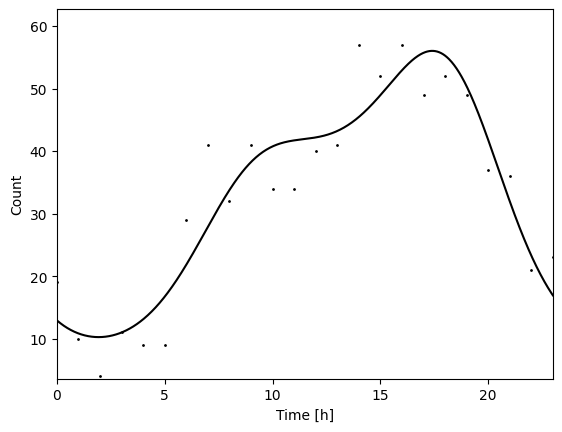

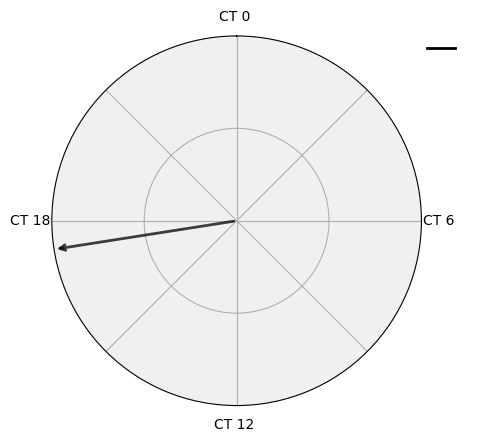

(<statsmodels.discrete.discrete_model.GeneralizedPoissonResultsWrapper at 0x23da442bfb0>,
 {'p': 1.2776058633278923e-10, 'RSS': 800.3029734668033, 'count': 787},
 {'period': 24,
  'amplitude': 22.884982256744287,
  'acrophase': 1.7261636202442556,
  'mesor': 33.1393710510544,
  'peaks': array([17.40654065]),
  'heights': array([56.02434705]),
  'troughs': array([1.93459346]),
  'heights2': array([10.25438879]),
  'max_loc': 3626,
  'period2': 24},
 array([0.00000000e+00, 4.80048005e-03, 9.60096010e-03, ...,
        4.79903990e+01, 4.79951995e+01, 4.80000000e+01]),
 array([12.92654544, 12.91236059, 12.89821958, ..., 12.9550469 ,
        12.94077419, 12.92654544]))

In [67]:
# cosinor.fit_me(X, Y, n_components = 2, period = 24, model_type = 'gen_poisson', save_to = "../PisanjeDiplome/angleskeSlike/kosinor-dez", plot=True, plot_margins=False)
cosinor.fit_me(X, Y, n_components = 2, period = 24, model_type = 'gen_poisson', plot=True, plot_margins=False)

## RhythmCount

In [68]:
# Ustvari pandas dataframe v formatu, ki bo primeren za uporabo RhythmCount
df_plot_RC = pd.DataFrame({
    "test": "HourlyAccidentsRain",  # konstantna oznaka vseh vrstic
    "X": accidents_per_hour.index,  # Ura (od 0 do 23)
    "Y": accidents_per_hour.values  # Število nesreč za tisto uro
})

In [69]:
count_models = ['gen_poisson', 'nb']
n_components = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

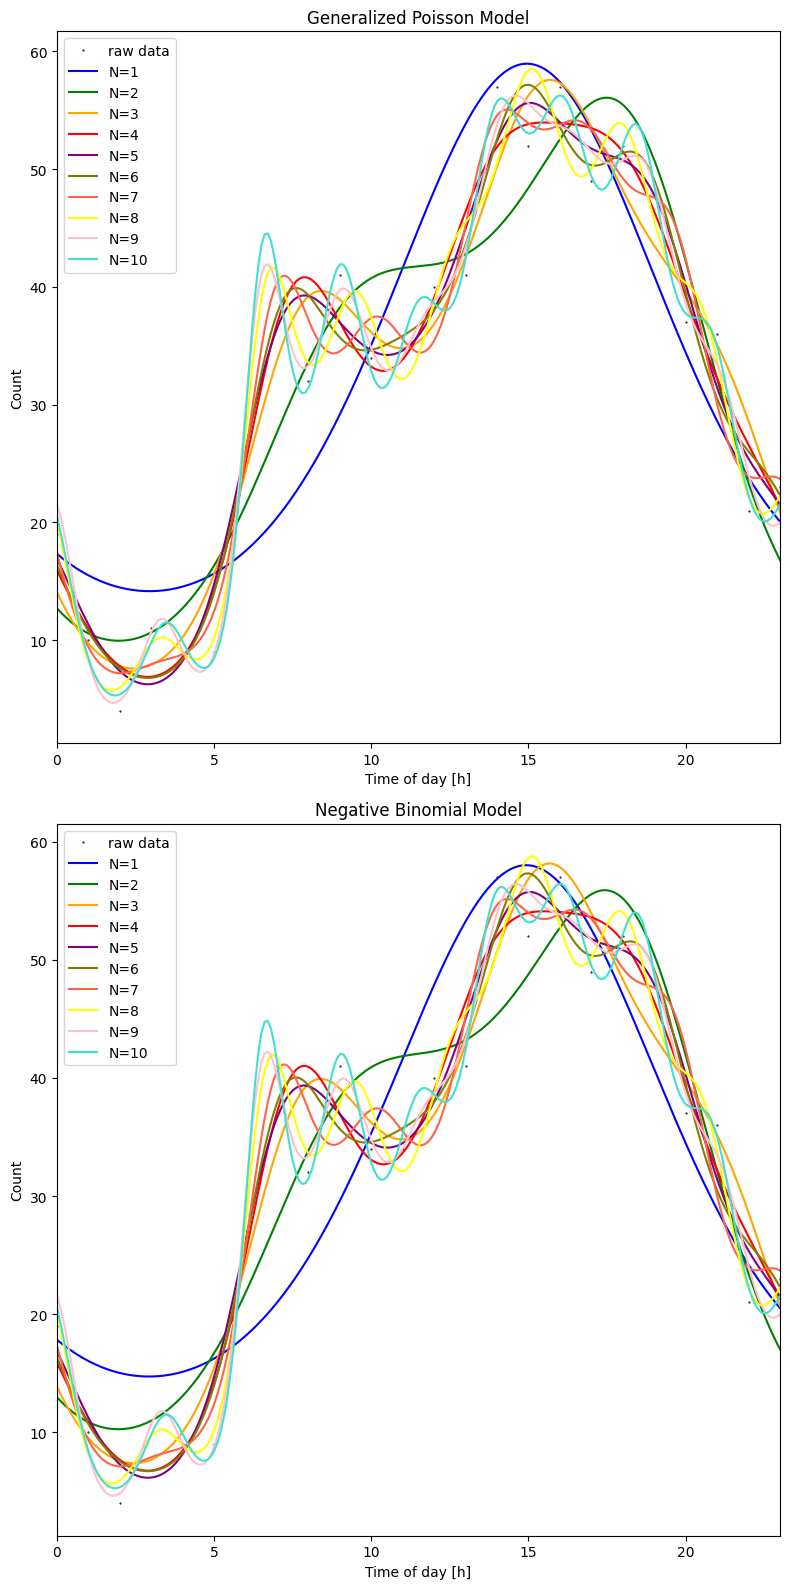

In [70]:
df_results_RC = dproc.fit_to_models(df_plot_RC, count_models, n_components, 24)

In [71]:
display(df_results_RC)

,count_model,n_components,amplitude,mesor,peaks,heights,llr_pvalue,RSS,AIC,BIC,log_likelihood,logs,mean(est),Y(est),X_test,Y_test
0,gen_poisson,1,22.39,36.56,[14.91],[58.95],1.020856e-08,1503.909322,177.574754,182.286969,-84.787377,"[-2.901938094294067, -2.8945526524035774, -4.5...",32.686672,"[17.33435060130224, 15.50872104991067, 14.4764...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[17.33435060130224, 17.112956588989157, 16.900..."
1,gen_poisson,2,23.05,33.01,[17.52],[56.06],3.693181e-10,821.029778,168.421718,175.490041,-78.210859,"[-3.845104891149955, -2.0412108719961477, -4.1...",32.636311,"[12.723624115475568, 10.581457713784618, 9.955...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[12.723624115475568, 12.42996525500247, 12.155..."
2,gen_poisson,3,24.99,32.59,[15.72],[57.58],2.698246e-12,442.109078,156.377260,165.801690,-70.188630,"[-3.239884381431539, -1.9638806067046453, -2.9...",32.714855,"[14.078269702884283, 9.728833534304481, 7.7893...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[14.078269702884283, 13.52543596831791, 12.998..."
3,gen_poisson,4,23.54,30.42,"[7.91, 15.52]","[40.82, 53.96]",4.731802e-12,343.901162,156.292229,168.072768,-68.146115,"[-2.6111455659619924, -2.0312755934399647, -2....",32.791667,"[15.944383656223808, 10.957489743234012, 7.794...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[15.944383656223808, 15.39772128943432, 14.857..."
4,gen_poisson,5,24.68,30.94,[15.02],[55.62],2.983834e-11,297.148275,159.484682,173.621328,-67.742341,"[-2.4244719313225147, -2.0824125325356366, -2....",32.791667,"[16.923494606326454, 11.333502568247459, 7.388...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[16.923494606326454, 16.373043819705444, 15.81..."
5,gen_poisson,6,25.18,31.98,"[15.02, 18.22]","[57.16, 51.49]",1.615348e-10,302.491390,162.788531,179.281284,-67.394265,"[-2.5161650861609814, -2.010742995981838, -2.8...",32.791667,"[16.386347311174884, 10.767417806413501, 7.630...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[16.386347311174884, 15.74938205193557, 15.120..."
6,gen_poisson,7,23.93,31.13,"[14.31, 16.52]","[55.05, 54.15]",2.739241e-10,289.410205,163.721368,182.570229,-65.860684,"[-2.3676715060528686, -1.9825106766719944, -2....",32.791667,"[17.362530155341908, 9.417224750908977, 7.1962...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[17.362530155341908, 16.39879997291588, 15.440..."
7,gen_poisson,8,26.41,32.14,"[15.12, 17.92]","[58.55, 53.93]",1.025005e-10,199.550067,161.208889,182.413858,-62.604445,"[-2.3331222569960097, -2.1743213507962293, -2....",32.791667,"[20.153326619508913, 8.205543439924513, 5.9740...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[20.153326619508913, 18.925411023484582, 17.59..."
8,gen_poisson,9,25.78,30.46,"[14.61, 18.42]","[56.24, 51.14]",1.470615e-10,92.265442,162.026954,185.588030,-61.013477,"[-2.4815395414239134, -2.146072753863221, -1.6...",32.791667,"[21.47411874800594, 8.317761252793382, 4.88172...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[21.47411874800594, 20.607503564340696, 19.487..."
9,gen_poisson,10,25.47,30.79,"[6.71, 14.11, 16.02, 18.42]","[44.54, 56.01, 56.26, 53.83]",3.401130e-10,26.204851,164.178230,190.095414,-60.089115,"[-2.367335633033001, -2.108924859249047, -1.79...",32.791667,"[20.54467361734502, 8.481912257105769, 5.39304...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[20.54467361734502, 19.387743078552457, 18.105..."


## Kateri model je najboljši?

#### Najprej pogledamo, kateri model je najboljši, nato kolikšno število komponent je najboljše.

In [72]:
best_count_model = dproc.get_best_count_model(df_results_RC, 'Vuong')
print("Best model: {}".format(best_count_model.count_model))
best_model = dproc.get_best_n_components(df_results_RC, 'Vuong', count_model=best_count_model['count_model'])
print("Number of components: {}".format(best_model.n_components))

Best model: gen_poisson
Number of components: 3


#### Najprej pogledamo, kolikšno število komponent je najboljše, nato, kateri model je najboljši. 

In [73]:
best_n_components = dproc.get_best_n_components(df_results_RC, 'Vuong')
print("Number of components: {}".format(best_n_components.n_components))
best_model = dproc.get_best_count_model(df_results_RC, 'Vuong', n_components=best_n_components['n_components'])
print("Best model: {}".format(best_model.count_model))

Number of components: 3
Best model: gen_poisson


### Prikaz najboljšega modela skupaj z intervali zaupanja

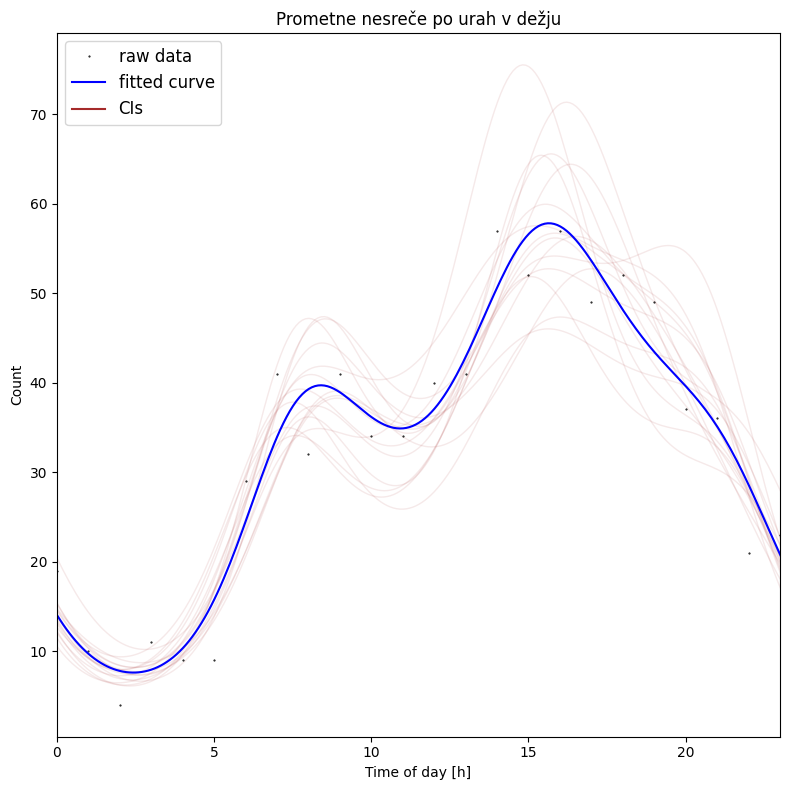

Intervali zaupanja:


,0,1
0,3.245142,3.424685
1,-0.577041,-0.382741
2,-0.730251,-0.445169
3,-0.356389,-0.189182
4,-0.318086,-0.142770
5,-0.245104,-0.057755
6,0.009276,0.213162
7,-0.544622,-0.025832


In [74]:
# print(type(best_model))
# print(type(best_n_components))

# print(best_n_components)

count_model = best_model.count_model
n_components = int(best_n_components.n_components)

CIs = plot.plot_model(df_plot_RC, count_model, n_components, title='Prometne nesreče po urah v dežju', plot_CIs=True)
print('Intervali zaupanja:')
display(CIs)

### Parametri izbranega modela

In [75]:
CIs_params = dproc.calculate_confidence_intervals_parameters(df_plot_RC, n_components, count_model, best_model['peaks'])
best_model = pd.concat([best_model, pd.Series(CIs_params)], axis=0)
best_model=best_model[['count_model','n_components','amplitude', 'mesor', 'peaks', 'heights','amplitude_CIs','mesor_CIs','peaks_CIs','heights_CIs']]
print('Parametri modela in njihovi intervali zaupanja:')
display(best_model.to_frame())

Parametri modela in njihovi intervali zaupanja:


,0
count_model,gen_poisson
n_components,3
amplitude,24.99
mesor,32.59
peaks,[15.72]
heights,[57.58]
amplitude_CIs,"[22.24, 28.49]"
mesor_CIs,"[29.3, 36.58]"
peaks_CIs,"[15.05, 16.54]"
heights_CIs,"[51.83, 64.79]"
